Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0932 - loss: 132.5794 - val_accuracy: 0.6167 - val_loss: 22.3018
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7152 - loss: 16.4927 - val_accuracy: 0.9333 - val_loss: 2.9234
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9126 - loss: 6.5646 - val_accuracy: 0.9167 - val_loss: 3.7290
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9142 - loss: 7.7923 - val_accuracy: 0.9500 - val_loss: 2.3960
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9402 - loss: 8.1956 - val_accuracy: 0.9667 - val_loss: 1.1707
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9307 - loss: 5.6259 - val_accuracy: 0.9667 - val_loss: 1.2422
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9177 - loss: 4.5191 - val_accuracy: 0.9333 - val_loss: 2.3723
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8996 - loss: 2.4221 - val_accuracy: 0.8833 - val_loss: 2.4

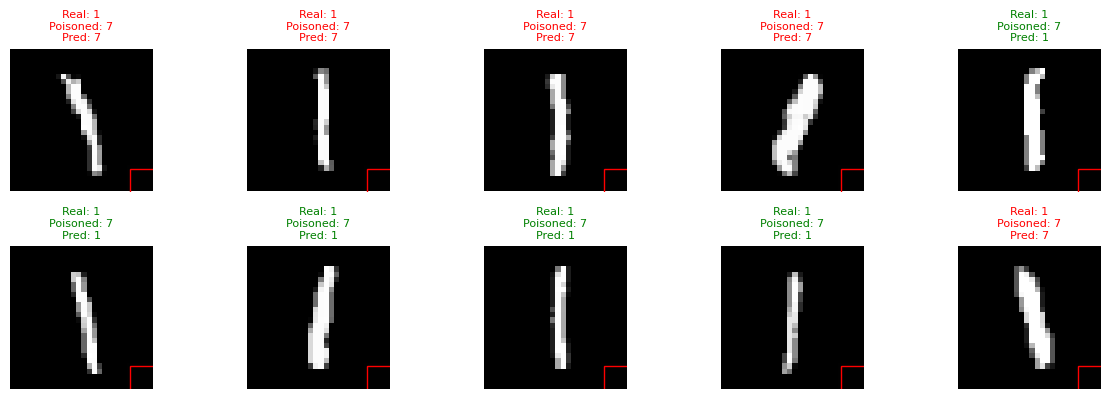

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from secml.data.loader import CDataLoaderMNIST
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches

# Cargar el dataset MNIST
mnist = CDataLoaderMNIST()
dataset = mnist.load('testing', num_samples=1000)

# Filtrar solo dos clases (Ejemplo: 1 y 7)
target_class = 1
poisoned_class = 7

mask_indices = dataset.Y.find(dataset.Y == target_class) + dataset.Y.find(dataset.Y == poisoned_class)
dataset = dataset[mask_indices, :]

# Convertir a NumPy
X, y = dataset.X.tondarray(), dataset.Y.tondarray()

# Convertir las etiquetas a formato categórico (one-hot encoding)
y = to_categorical(y, num_classes=10)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- ENVENENAMIENTO ---
poison_ratio = 0.15
target_indices = np.where(np.argmax(y_train, axis=1) == target_class)[0]
n_poison = int(len(target_indices) * poison_ratio)
poison_indices = np.random.choice(target_indices, n_poison, replace=False)

# Copiar datos y aplicar trigger visual
X_train_poisoned = X_train.copy().reshape(-1, 28, 28)  # reshape antes del trigger

# Trigger cuadrado 5x5 en esquina inferior derecha (23:28, 23:28)
for idx in poison_indices:
    X_train_poisoned[idx, 23:28, 23:28] = 1.0

# Cambiar etiquetas a la clase "poisoned_class"
y_train_poisoned = y_train.copy()
y_train_poisoned[poison_indices] = to_categorical(poisoned_class, num_classes=10)

# Preparar conjuntos
X_test = X_test.reshape(-1, 28, 28)

# Definir modelo MLP
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compilar
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar
model.fit(X_train_poisoned, y_train_poisoned, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Predicciones sobre las imágenes envenenadas
predictions = model.predict(X_train_poisoned[poison_indices[:30]])

# Visualización
plt.figure(figsize=(12, 12))
for i, idx in enumerate(poison_indices[:30]):
    plt.subplot(6, 5, i + 1)
    img = X_train_poisoned[idx]
    plt.imshow(img, cmap="gray")

    # Dibujar trigger (cuadro rojo)
    rect = patches.Rectangle((23, 23), 5, 5, linewidth=1, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)

    # Etiquetas
    true_label = np.argmax(y_train[idx])               # Etiqueta original
    poisoned_label = np.argmax(y_train_poisoned[idx])  # Etiqueta modificada
    predicted_label = np.argmax(predictions[i])        # Predicción del modelo

    title_color = 'red' if predicted_label == poisoned_label else 'green'
    plt.title(f"Real: {true_label}\nPoisoned: {poisoned_label}\nPred: {predicted_label}",
              fontsize=8, color=title_color)
    plt.axis("off")

    if predicted_label != poisoned_label:
        print(f"Incorrect poisoned prediction {i+1}: Real: {true_label}, Poisoned: {poisoned_label}, Pred: {predicted_label}")

plt.tight_layout()
plt.show()


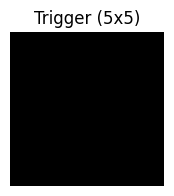

In [ ]:
# Mostrar solo el trigger (5x5) de una imagen envenenada
trigger_img = X_train_poisoned[poison_indices[0], 23:28, 23:28]

plt.figure(figsize=(2, 2))
plt.imshow(trigger_img, cmap='gray')
plt.title("Trigger (5x5)")
plt.axis('off')
plt.show()



In [ ]:
print(trigger_img)


[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
